In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
from random import randrange
from PIL import Image
import os
import random
from sklearn.decomposition import TruncatedSVD #importing just to do truncatedSVD for me, I didn't have the time(and energy :) ) to implement by myself.

In [19]:
##k-Cross_validation_split:
def cross_validation_split(dataset,k):
    k_folds = list()
    copy_data = list(dataset)
    fold_size = int(len(dataset)/k)
    
    for i in range(k):
        fold = list()
        for j in range(fold_size):
            fold.append(copy_data.pop(randrange(len(copy_data))))
        k_folds.append(fold)
    return k_folds    

In [2]:
data = pd.read_csv('health_data.csv')
data.head()

,age,restbps,chol,category
0,26,109,243,0
1,27,106,156,0
2,28,107,225,0
3,27,105,277,0
4,30,96,221,0


In [3]:
X = data.to_numpy()[:, :3]
Y = data.to_numpy()[:, 3]
split = 0.8 #using 70:30 split, random each time
train_samples = np.random.choice(X.shape[0], int(split*X.shape[0]))
test_samples = np.array([i for i in range(X.shape[0]) if i not in list(train_samples)])

X_train = X[[train_samples]]
Y_train = Y[[train_samples]]

X_test = X[[test_samples]]
Y_test = Y[[test_samples]]

X_0 = X_train[Y_train == 0]
X_1 = X_train[Y_train == 1]

X_test_0 = X_test[Y_test == 0]
X_test_1 = X_test[Y_test==1]
print(X_test.shape)

(316, 3)


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  

In [4]:
X_00 = data[data['category'] == 0].to_numpy()[:, :3]
X_11 = data[data['category'] == 1].to_numpy()[:, :3]

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


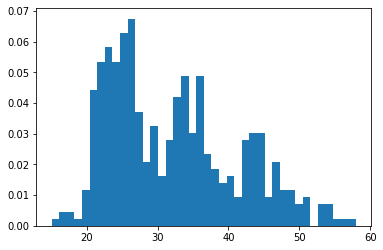

In [5]:
hist1 = plt.hist(X_00[:, 0], bins=40, normed=True)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


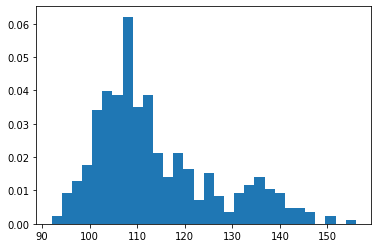

In [6]:
hist2 = plt.hist(X_00[:, 1], bins=30, normed=True)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


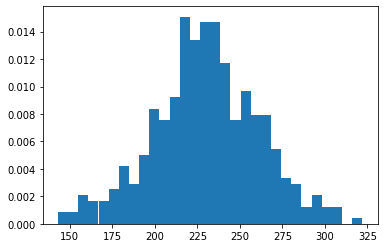

In [7]:
hist3 = plt.hist(X_00[:, 2], bins=30, normed=True)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


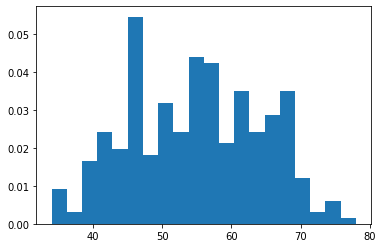

In [8]:
hist11 = plt.hist(X_11[:, 0], bins=20, normed=True)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


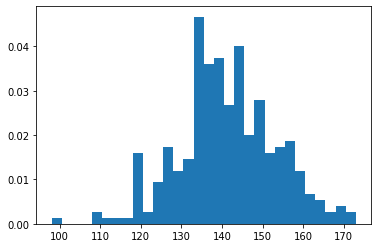

In [9]:
hist12 = plt.hist(X_11[:, 1], bins=30, normed=True)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


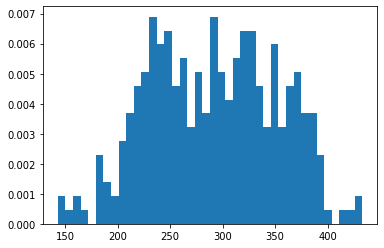

In [10]:
hist13 = plt.hist(X_11[:, 2], bins=40, normed=True)

In [2]:
#Hypercube_Kernel
def hypercube_kernel(h, x, x_i):
    assert (x.shape == x_i.shape)
    return (x - x_i) / (h)


#Window_function   
def parzen_window_func(x_vec):
    for row in x_vec:
        if np.abs(row) > (1/2):
            return 0
        return 1

#Estimation
def parzen_estimation_for_hyper_cube(x_samples, point_x, h, d):
    dimensions = x_samples.shape[1]
    assert (len(point_x) == dimensions)
    k_n = 0
    for row in x_samples:
        x_i = hypercube_kernel(h=h, x=point_x, x_i=row)
        k_n += parzen_window_func(x_i)
    return (k_n / len(x_samples)) / (h**d)

In [3]:
def pdf_multivariate_gauss(x, mu, cov):
    assert(mu.shape[0] > mu.shape[1])
    assert(x.shape[0] > x.shape[1])
    assert(cov.shape[0] == cov.shape[1])
    assert(mu.shape[0] == cov.shape[0])
    assert(mu.shape[0] == x.shape[0])
    part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).T.dot(np.linalg.inv(cov))).dot((x-mu))
    return float(part1 * np.exp(part2))

In [4]:
#Gaussian_kernel_and_window_function
def gaussian_window_function(cov, x, x_i):
    assert (x.shape == x_i.shape)
    assert(cov.shape[0] == cov.shape[1])
    assert(x_i.shape[0] == cov.shape[0])
    return pdf_multivariate_gauss(x, x_i,cov)


#Estimation
def parzen_estimation_for_gaussian(x_samples, point_x, cov):
    point_x = point_x.reshape((3,1))
    prob = 0.0
    for row in x_samples:
        row = row.reshape((3,1))
        prob += gaussian_window_function(cov,point_x,row)
    return prob 

In [14]:
#prior calculation
P = [float(len(X_0))/ float(len(X_0) + len(X_1)) ,float(len(X_1))/ float(len(X_0) + len(X_1)) ]
P

[0.5803571428571429, 0.41964285714285715]

# Hyper_Cube

In [45]:
#calculation of posterior
def posterior(X_train_0,X_train_1, data, P,h,d):
    prob = np.zeros(no_of_classes, dtype = np.float64)
    class_probabilities = [parzen_estimation_for_hyper_cube(X_train_0, data, h, d), parzen_estimation_for_hyper_cube(X_train_1, data, h, d)]
    
    #print(probabilities)
    for i in range(2):
        prob[i] = class_probabilities[i]*P[i]
    return prob

In [46]:
def prediction(data, X_train_0, X_train_1,P, h, Th):
    Probabilities = posterior(X_train_0, X_train_1, data, P, h, X_train.shape[1])
    Probabilities = Probabilities/sum(Probabilities)
    #print(Probabilities)
    if Probabilities[1] > Th:
        return 1
    else:
        return 0

In [47]:
#computing accuracy on test data.
C = np.zeros((2,2)) #[[]]
for i in range((X_test_0.shape[0])):
    y_pred = prediction(X_test_0[i], X_0,X_1, P, 1, 0.5)
    C[y_pred, 0] += 1
for i in range((X_test_1.shape[0])):
    y_pred = prediction(X_test_1[i], X_0, X_1, P, 1, 0.5)
    C[y_pred, 1] += 1

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
C

array([[156.,  33.],
       [ 22.,  92.]])

In [49]:
acc = (C[0,0] + C[1,1])/np.sum(C)
print(acc)

0.8184818481848185


In [50]:
precision = (C[1,1])/(C[1,0] + C[1,1])
precision

0.8070175438596491

In [51]:
Recall = (C[1,1])/(C[0,1] + C[1,1])
Recall

0.736

In [52]:
from tqdm import tqdm
Precision = []
Recall = []
ACC = []
F1_score = []
kk = range(1,300)
for h in tqdm(np.linspace(0.01,10,100)):
    C = np.zeros((2,2)) #[[]]
    for i in range((X_test_0.shape[0])):
        y_pred = prediction(X_test_0[i], X_0,X_1, P, h, 0.5)
        C[y_pred, 0] += 1
    for i in range((X_test_1.shape[0])):
        y_pred = prediction(X_test_1[i], X_0, X_1, P, h, 0.5)
        C[y_pred, 1] += 1
    acc = (C[0,0] + C[1,1])/np.sum(C) 
    pr = C[1,1]/(C[1,1] + C[1,0])
    rec = C[1,1]/(C[1,1] + C[0,1])
    f1 = 2*(pr*rec)/(pr + rec)
    Precision.append(pr)
    Recall.append(rec)
    F1_score.append(f1)
    ACC.append(acc)
#plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC curve');

  0%|          | 0/100 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


In [53]:
kk = np.linspace(0.01,10,100)

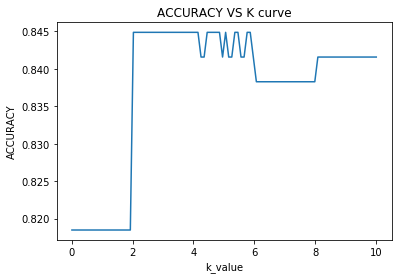

In [54]:
plt.plot(kk ,ACC, '-')
plt.xlabel('k_value'); plt.ylabel('ACCURACY'); plt.title('ACCURACY VS K curve');

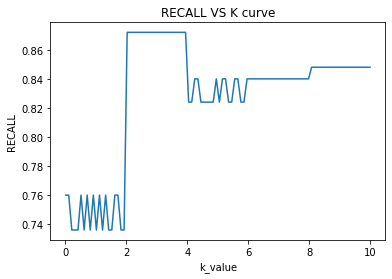

In [55]:
plt.plot(kk, Recall, '-')
plt.xlabel('k_value'); plt.ylabel('RECALL'); plt.title('RECALL VS K curve');

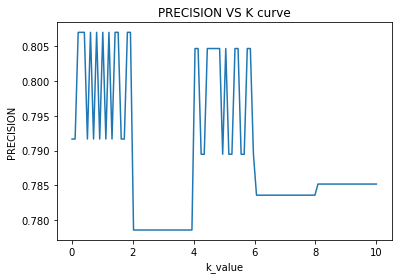

In [56]:
plt.plot(kk, Precision, '-')
plt.xlabel('k_value'); plt.ylabel('PRECISION'); plt.title('PRECISION VS K curve');

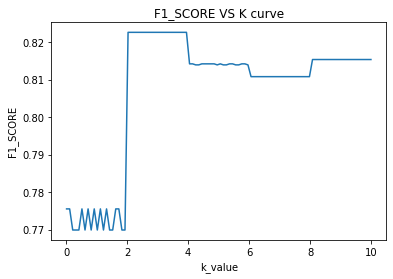

In [57]:
plt.plot(kk, F1_score, '-')
plt.xlabel('k_value'); plt.ylabel('F1_SCORE'); plt.title('F1_SCORE VS K curve');

# Gaussian Window function

In [15]:
#calculation of posterior
def posterior(X_train_0,X_train_1, data, P,cov):
    prob = np.zeros(2, dtype = np.float64)
    class_probabilities = [parzen_estimation_for_gaussian(X_train_0, data,cov ), parzen_estimation_for_gaussian(X_train_1, data,cov)]
    
    #print(probabilities)
    for i in range(2):
        prob[i] = class_probabilities[i]*P[i]
    return prob

In [16]:
def prediction(data, X_train_0, X_train_1,P, cov, Th):
    Probabilities = posterior(X_train_0, X_train_1, data, P, cov)
    Probabilities = Probabilities/sum(Probabilities)
    #print(Probabilities)
    if Probabilities[1] > Th:
        return 1
    else:
        return 0

In [17]:
#computing accuracy on test data.
C = np.zeros((2,2)) #[[]]
cov = np.eye(X_train.shape[1],dtype = np.float)
for i in range((X_test_0.shape[0])):
    y_pred = prediction(X_test_0[i], X_0,X_1, P, cov, 0.5)
    C[y_pred, 0] += 1
for i in range((X_test_1.shape[0])):
    y_pred = prediction(X_test_1[i], X_0, X_1, P, cov, 0.5)
    C[y_pred, 1] += 1

In [18]:
C

array([[147.,  41.],
       [ 26., 102.]])

In [33]:
from tqdm import tqdm
Precision = []
Recall = []
ACC = []
F1_score = []
kk = range(1,300)
for h in tqdm(np.linspace(0.01,40,400)):
    C = np.zeros((2,2)) #[[]]
    cov = np.eye(X_train.shape[1],dtype = np.float)
    for i in range((X_test_0.shape[0])):
        y_pred = prediction(X_test_0[i], X_0,X_1, P, cov*h, 0.5)
        C[y_pred, 0] += 1
    for i in range((X_test_1.shape[0])):
        y_pred = prediction(X_test_1[i], X_0, X_1, P, cov*h, 0.5)
        C[y_pred, 1] += 1
    acc = (C[0,0] + C[1,1])/np.sum(C) 
    pr = C[1,1]/(C[1,1] + C[1,0])
    rec = C[1,1]/(C[1,1] + C[0,1])
    f1 = 2*(pr*rec)/(pr + rec)
    Precision.append(pr)
    Recall.append(rec)
    F1_score.append(f1)
    ACC.append(acc)


  0%|          | 0/400 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until

 76%|███████▋  | 306/400 [29:40<30:59, 19.78s/it]


100%|██████████| 400/400 [1:02:21<00:00,  9.35s/it]


In [34]:
cov = np.eye(X_train.shape[1],dtype = np.float)*2
cov

array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]])

In [35]:
kk = np.linspace(0.01,30,400)

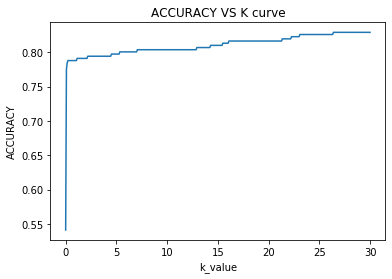

In [36]:
plt.plot(kk ,ACC, '-')
plt.xlabel('k_value'); plt.ylabel('ACCURACY'); plt.title('ACCURACY VS K curve');

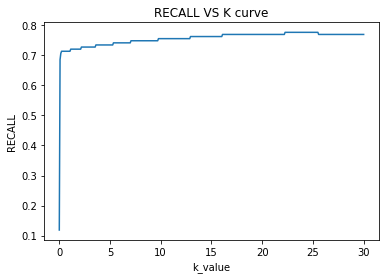

In [37]:
plt.plot(kk, Recall, '-')
plt.xlabel('k_value'); plt.ylabel('RECALL'); plt.title('RECALL VS K curve');

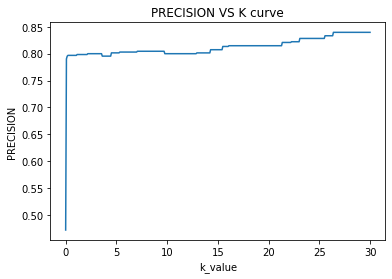

In [38]:
plt.plot(kk, Precision, '-')
plt.xlabel('k_value'); plt.ylabel('PRECISION'); plt.title('PRECISION VS K curve');

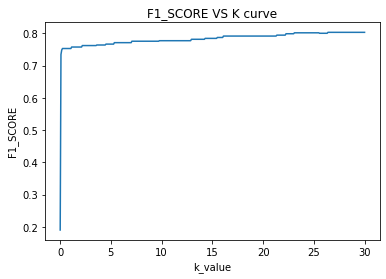

In [39]:
plt.plot(kk, F1_score, '-')
plt.xlabel('k_value'); plt.ylabel('F1_SCORE'); plt.title('F1_SCORE VS K curve');

In [40]:
print(ACC[-1])

0.8291139240506329


In [41]:
print(F1_score[-1])

0.8029197080291971


In [42]:
print(Precision[-1])

0.8396946564885496


In [43]:
print(Recall[-1])

0.7692307692307693


## Question3

In [2]:
import os
IMAGE_PATH = './Medical_MNIST'
print(os.path.abspath(IMAGE_PATH))
n_components = 20

C:\Users\rockt\Assignment1_git\ELL409_Assignment1\Medical_MNIST


In [3]:
#data_loader
#!DEL *.npz
from tqdm import tqdm
split = 0.7 #using 70:30 split, random each time
def data_loader():
    X = []
    Y = []
    X_test = []
    Y_test = []
    
    i = 0
    for folder in os.listdir(os.path.abspath(IMAGE_PATH)):
        IMAGE_DIR = os.path.join(IMAGE_PATH, folder)
        print("Reading" + IMAGE_DIR)
        files = os.listdir(IMAGE_DIR)
        random.shuffle(files)
        j=0
        for file in tqdm(files):
            if j < int(len(files)*split):
                X.append((np.asarray(Image.open(os.path.join(IMAGE_DIR, file)))).reshape(-1))
                Y.append(i)
            else:
                X_test.append((np.asarray(Image.open(os.path.join(IMAGE_DIR, file)))).reshape(-1))
                Y_test.append(i)
            j += 1
        
        i += 1
    print('Completed Loading Data. Saving as np file so that can directy load array nexttime')
    np.savez('q3data.npz', X = np.array(X), Y = np.array(Y), X_test=X_test, Y_test = Y_test)
    return np.array(X), np.array(Y), np.array(X_test), np.array(Y_test)

if 'q3data.npz' in os.listdir('./'):
    zfile = np.load('q3data.npz')
    X = zfile['X']
    Y = zfile['Y']
    X_test = zfile['X_test']
    Y_test = zfile['Y_test']
else:
    X, Y, X_test, Y_test = data_loader()

In [4]:
print(f'X.shape = {X.shape}') #oof!
print(f'X_test.shape = {X_test.shape}')

X.shape = (41267, 4096)
X_test.shape = (17687, 4096)


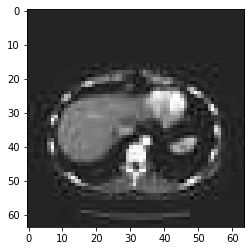

In [5]:
#Visualizing the images.
plt.imshow(X[0].reshape(64, -1), cmap='gray')

In [6]:
#Lets try to do PCA on the input images??
h, w = 64, 64
'''
def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    
    return projected, components, mean, centered_data
    #credits to https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184 for helping me write PCA
    #and saving me a few hours.
'''
"""It helps visualising the portraits from the dataset."""
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
'''
n_components = 50
P, C, M, X_centered=pca(X[:1000], n_pc=n_components)
#P->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)
eigenscans = C.reshape((n_components, h, w))
eigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]
plot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) 
'''

'\nn_components = 50\nP, C, M, X_centered=pca(X[:1000], n_pc=n_components)\n#P->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)\neigenscans = C.reshape((n_components, h, w))\neigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]\nplot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) \n'

In [7]:
X_samples = list()
Y_samples = list()
X_samples.append(list(X))
Y_samples.append(list(Y))
X_samples.append(list(X_test))
Y_samples.append(list(Y_test))
X_samples = sum(X_samples, [])
Y_samples = sum(Y_samples, [])
X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

In [8]:
def fastpca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    svd = TruncatedSVD(n_components=n_pc, n_iter=7, random_state=42)
    svd.fit(X)
    #U, S, V = np.linalg.svd(centered_data)
    components = svd.components_
    #projected = U[:,:n_pc]*S[:n_pc]
    projected = svd.transform(X)
    return projected, components, mean, centered_data

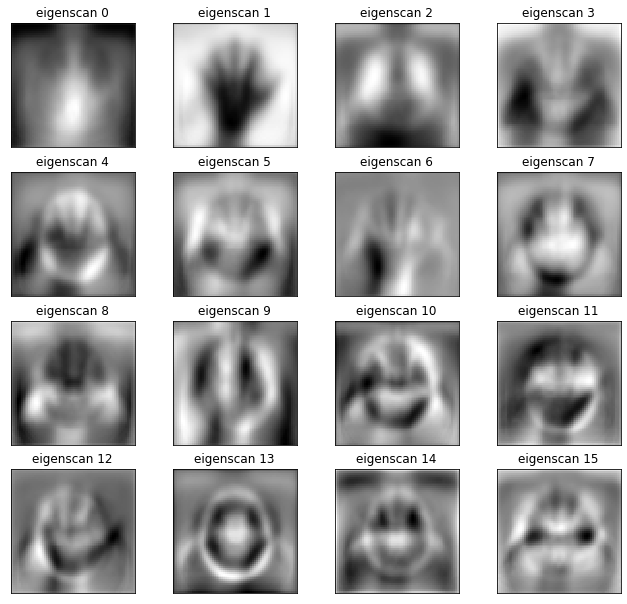

In [9]:
X_red, C, M, X_centered=fastpca(X_samples, n_pc=n_components)
#X_red->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)
eigenscans = C.reshape((n_components, h, w))
eigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]
plot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) 

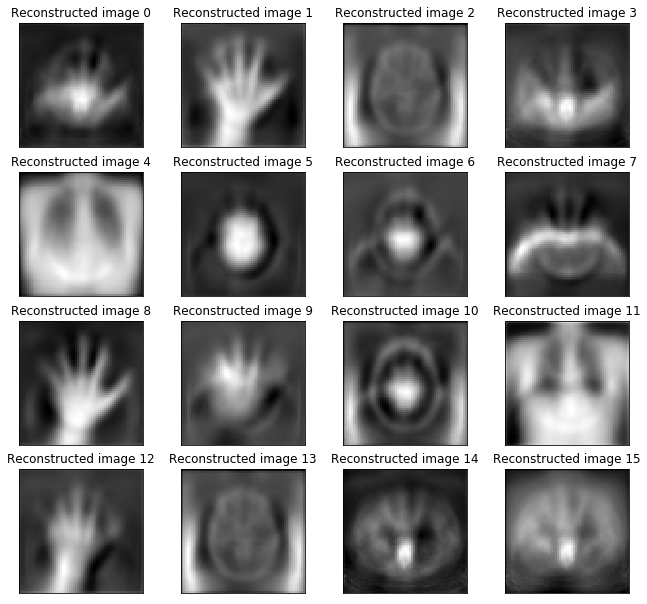

In [10]:
def reconstruction(Y, C, M, h, w, image_index):
    n_samples, n_features = Y.shape
    weights = np.dot(Y, C.T)
    centered_vector=np.dot(weights[image_index, :], C)
    recovered_image=(M+centered_vector).reshape(h, w)
    return recovered_image
arr = np.random.choice(X.shape[0], 16)
recovered_images=[reconstruction(X_centered, C, M, h, w, i) for i in arr]
plot_portraits(recovered_images, [f"Reconstructed image {i}" for i in range(len(recovered_images))], h, w, n_row=4, n_col=4)

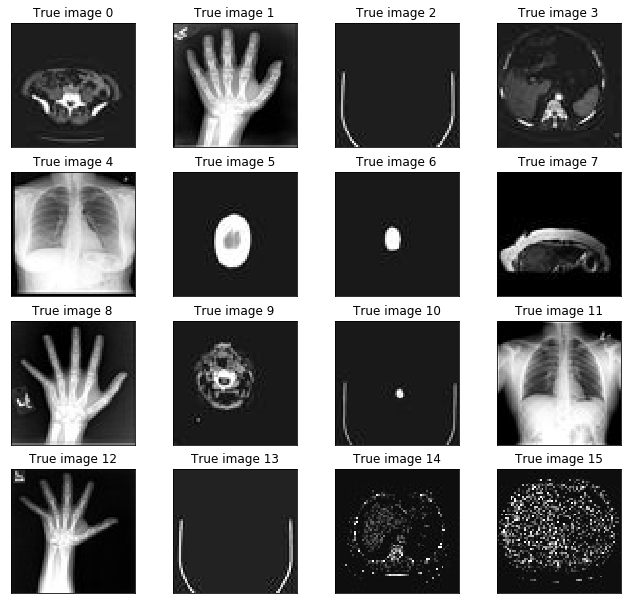

In [11]:
true_images = [X[i].reshape(h, w) for i in arr]
plot_portraits(true_images, [f"True image {i}" for i in range(len(recovered_images))], h, w, n_row=4, n_col=4)

In [12]:
Y_samples = Y_samples.reshape((58954,1))

In [13]:
X_final = np.append(X_red, Y_samples, axis = 1)
X_final.shape

(58954, 21)

In [14]:
no_of_classes = 6

In [17]:
def separate(X, no_of_classes):
    data = dict()
    for i in range(no_of_classes):
        data["X_"+str(i)] = X[X[:,20] == i]
    return data

In [18]:
data = separate(X_final, 6)

# HyperCube

In [20]:
no_of_classes = 6

In [7]:
#calculation of posterior
def posterior(data_train, data, P,h):
    prob = np.zeros(no_of_classes, dtype = np.float64)
    class_probabilities  = np.zeros(no_of_classes)
    features = 0;
    for i in range(no_of_classes):
        class_probabilities[i] = parzen_estimation_for_hyper_cube(data_train[i,:], data, h, features)
    #print(probabilities)
    for i in range(no_of_classes):
        prob[i] = class_probabilities[i]*P[i]
    return prob

In [8]:
def prediction(data, X_train,P, h, Th):
    Probabilities = posterior(X_train, data, P, h)
    Probabilities = Probabilities/sum(Probabilities)
    #print(Probabilities)
    if Probabilities[1] > Th:
        return 1
    else:
        return 0

In [11]:
X_test =np.array([])
#computing accuracy on test data.
C = np.zeros((no_of_classes,no_of_classes)) #[[]]
for j in range(no_of_classes):
    for i in range((X_test.shape[0])):
        y_pred = prediction(X_test[i], X, P, 1,0.5)
        C[y_pred, j] += 1

## Gaussian